# Dam Breach Results

## OverviewThis notebook demonstrates extracting **dam breach analysis results** from HEC-RAS HDF5 files. Breach modeling simulates catastrophic failure of dams or levees.**Breach Analysis Components**:- **Breach Formation**: Time-dependent widening and deepening of breach- **Breach Outflow**: Flow through developing breach opening- **Downstream Propagation**: Flood wave routing downstream- **Reservoir Drawdown**: Water surface in reservoir during breach### HDF5 Structure for Breach Results```/Results/Unsteady/Output/├── Output Blocks/│   └── Base Output/│       └── Unsteady Time Series/│           ├── SA/2D Area Conn/│           │   └── {Breach Name}/│           │       ├── Breach/│           │       │   ├── Bottom Width/      # Breach width at bottom│           │       │   ├── Top Width/         # Breach width at top│           │       │   ├── Bottom Elevation/  # Breach invert elevation│           │       │   ├── Weir Flow/         # Weir-like flow component│           │       │   └── Pipe Flow/         # Pressure flow component│           │       ├── Flow/                  # Total breach outflow│           │       └── Upstream Water Surface/ # Reservoir WSE```**Breach Parameters** (time-varying):- **Width**: Breach widens over time (linear, sine, or user-defined)- **Invert**: Breach deepens (erodes downward)- **Flow**: Combination of weir and orifice flow- **Formation Time**: Time from initiation to full formation### Breach Modeling Theory**Failure Modes**:- **Overtopping**: Erosion starts at crest, progresses downstream- **Piping**: Internal erosion, sudden collapse- **Earthquake**: Instantaneous breach- **Programmed**: User-defined breach progression**Flow Equations**:```Qweir = Cw * Ltop * H^1.5           (Weir flow - unsubmerged)Qorifice = Co * Abottom * sqrt(H)   (Orifice flow - submerged)Qtotal = Qweir + Qorifice            (Combined)```Where:- Cw = weir coefficient- Ltop = top width of breach- H = head difference- Co = orifice coefficient- Abottom = bottom area of breach### Reference Documentation- [HEC-RAS User's Manual, Chapter 16: Dam Break Analysis](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)- [FEMA Dam Safety Guidelines](https://www.fema.gov/emergency-managers/risk-management/dam-safety) - Breach modeling requirements- [ASDSO Breach Parameters](http://damsafety.org/) - Recommended breach parameter selection### Regulatory ContextDam breach analysis typically required for:- **Hazard Classification**: Determine dam hazard potential (High, Significant, Low)- **Emergency Action Plans (EAP)**: Inundation mapping for evacuation planning- **Dam Safety Inspections**: Assess consequences of failure- **FEMA Flood Maps**: Breach scenarios for floodplain mapping

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfResultsBreach, HdfResultsPlan, HdfStruc, RasBreach, RasCmdr, RasExamples, RasPlan, get_logger, init_ras_project, ras

# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander


2025-12-16 21:37:02 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


✓ Loaded: C:\GH\ras-commander\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "01"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis

print(f"Configuration: {PROJECT_NAME} project, Plan {PLAN}, RAS {RAS_VERSION}")

# Dam Breach Results Extraction and Sensitivity Analysis

This notebook demonstrates:
1. **Extracting baseline breach results** from HDF files
2. **Reading breach parameters** from plan files
3. **Modifying parameters iteratively** (one parameter at a time)
4. **Comparing results** across different scenarios
5. **Visualizing sensitivity** to parameter changes

**Project:** BaldEagleCrkMulti2D (HEC-RAS Example)  
**Baseline Plan:** 02  
**Version:** 6.6

**Workflow:**
- Extract baseline results
- Clone plan and modify one parameter
- Re-extract results and compare
- Repeat for multiple parameters
- Plot all scenarios together

## Setup and Imports

In [2]:
# Standard imports
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil

## 1. Extract and Initialize Project

In [3]:
# Extract the BaldEagleCrkMulti2D example project using static method
example_project_folder = RasExamples.extract_project(PROJECT_NAME, suffix="16")
print(f"Extracted project to: {example_project_folder}")

# Verify the path exists
print(f"BaldEagleCrkMulti2D project exists: {example_project_folder.exists()}")

# Set project_path variable for compatibility with rest of notebook
project_path = example_project_folder

2025-12-16 21:37:06 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip


2025-12-16 21:37:06 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-16 21:37:06 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-16 21:37:06 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 21:37:06 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_16'


2025-12-16 21:37:08 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16


Extracted project to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16
BaldEagleCrkMulti2D project exists: True


In [4]:
# Extract the BaldEagleCrkMulti2D example project using static method
example_project_folder = RasExamples.extract_project(PROJECT_NAME, suffix="16")
print(f"Extracted project to: {example_project_folder}")

# Verify the path exists
print(f"BaldEagleCrkMulti2D project exists: {example_project_folder.exists()}")

# Set project_path variable for compatibility with rest of notebook
project_path = example_project_folder

2025-12-16 21:37:09 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 21:37:09 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_16'


2025-12-16 21:37:09 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_16' already exists. Deleting existing folder...


2025-12-16 21:37:09 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_16' has been deleted.


2025-12-16 21:37:11 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16


Extracted project to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16
BaldEagleCrkMulti2D project exists: True


In [5]:
# Initialize the project
init_ras_project(project_path, RAS_VERSION)
print(f"\nInitialized project: {ras.project_name}")
print(f"\nAvailable plans:")
ras.plan_df

# This is the SA to 2D Dam Break Run
template_plan = PLAN

2025-12-16 21:37:11 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.rasmap



Initialized project: BaldEagleDamBrk

Available plans:


## 2. BASELINE: Extract Existing Results from Plan 02

First, extract and analyze the baseline breach behavior from the existing Plan 02 results.

### Important Note: HDF Results Files

**This example project may not include pre-computed HDF results** (.p02.hdf files). These files are generated when HEC-RAS runs a simulation.

**If you encounter "HDF file not found" errors:**
1. Option A: Run HEC-RAS simulation for Plan 02 first
2. Option B: Use the RasCmdr class to run simulation from Python (see cell below)
3. Option C: Use a different project with existing results (e.g., Scott County)

**The notebook will gracefully handle missing results and still demonstrate parameter modification.**

In [6]:
# Initialize variables to None (prevents NameError in later cells)
target_structure = None
baseline_ts = pd.DataFrame()
baseline_summary = pd.DataFrame()
baseline_params = None
baseline_geom = []
scenarios = {}
summaries = {}

### 2.1 Identify Breach Structures

In [7]:
# List breach structures from PLAN FILE (for parameter operations)
# This ensures structure names match between listing and read_breach_block()
breach_structures_list = RasBreach.list_breach_structures_plan(template_plan)

print("Breach Structures in Plan File:")
for struct in breach_structures_list:
    if struct['structure']:  # Filter empty names
        status = "ACTIVE" if struct['is_active'] else "INACTIVE"  
        location = f"{struct['river']}/{struct['reach']}/RS {struct['station']}" if struct['river'] else "No location"
        print(f"  - {struct['structure']}: {status} ({location})")

# Get active structure names for parameter operations
breach_structures = [s['structure'] for s in breach_structures_list 
                    if s['structure'] and s['is_active']]

if breach_structures:
    target_structure = breach_structures[0]
    print(f"\nTarget structure for analysis: {target_structure}")
    print(f"  This name will work with RasBreach.read_breach_block()")
else:
    print("\nWARNING: No active breach structures found!")
    target_structure = None


2025-12-16 21:37:11 - ras_commander.RasBreach - INFO - Found 2 breach structures in BaldEagleDamBrk.p19


Breach Structures in Plan File:
  - Dam: ACTIVE (No location)

Target structure for analysis: Dam
  This name will work with RasBreach.read_breach_block()


if target_structure:
    try:
        # Extract complete breach time series from HDF results
        baseline_ts = HdfResultsBreach.get_breach_timeseries("02", target_structure)
        
        print(f"Baseline Time Series Extracted: {baseline_ts.shape}")
        print(f"\nColumns: {list(baseline_ts.columns)}")
        print(f"\nFirst few timesteps:")
        print(baseline_ts.head())
        
        # Get summary statistics from HDF results
        baseline_summary = HdfResultsBreach.get_breach_summary("02", target_structure)
        print(f"\nBaseline Summary Statistics:")
        print(baseline_summary.to_string(index=False))
        
        # Store baseline for later comparison
        scenarios = {
            'Baseline (Plan 02)': baseline_ts.copy()
        }
        summaries = {
            'Baseline (Plan 02)': baseline_summary.copy()
        }
    except (FileNotFoundError, OSError) as e:
        print(f"Could not extract baseline time series: {e}")
        print("Continuing with parameter analysis only...")
        baseline_ts = pd.DataFrame()
        baseline_summary = pd.DataFrame()
        scenarios = {}
        summaries = {}
else:
    print("Skipping baseline extraction - no breach structure available")
    scenarios = {}
    summaries = {}

In [8]:
template_plan

'19'

In [9]:
# Read current parameters
params = RasBreach.read_breach_block(template_plan, "Dam")
geom = [x.strip() for x in params['values']['Breach Geom'].split(',')]

# Update Final Bottom Elevation (index 2)
geom[2] = 605  # New elevation in feet

# Write back
RasBreach.update_breach_block(template_plan, "Dam", geom_values=geom)

2025-12-16 21:37:11 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p19


2025-12-16 21:37:11 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251216_213711.p19


2025-12-16 21:37:11 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p19


{'structure_name': 'Dam',
 'is_active': True,
 'river': '',
 'reach': '',
 'station': '',
 'values': {'Breach Loc': '                ,                ,        ,True,Dam',
  'Breach Method': ' 0',
  'Breach Geom': '5700,200,605,0.5,0.5,True,0.5,630,2,2.6',
  'Breach Start': 'True,661,,,False,,,0',
  'Breach Progression': ' 2',
  'Simplified Physical Breach Downcutting': ' 2',
  'Simplified Physical Breach Widening': ' 2',
  'Starting Notch Depth': ' 3.402823E+38',
  'Initial Piping Diameter': ' 3.402823E+38',
  'Mass Wasting Options': ' 0',
  'Mass Wasting Width': ' 3.402823E+38',
  'Mass Wasting Duration': ' 3.402823E+38',
  'Mass Wasting Final Bottom Elevation': ' 3.402823E+38',
  'Breach Use User Defined Growth Ratio': '-1',
  'Breach User Defined Growth Ratio': '1'},
 'table_rows': {'Breach Progression': [[0.0, 0.0, 1.0, 1.0]],
  'Simplified Physical Breach Downcutting': [[0.0, 0.0, 1.0, 1.0]],
  'Simplified Physical Breach Widening': [[0.0, 0.0, 1.0, 1.0]]}}

In [10]:
if target_structure:
    # Read breach parameters from plan file
    baseline_params = RasBreach.read_breach_block("02", target_structure)
    
    print(f"Baseline Parameters for {target_structure}:")
    print("=" * 80)
    print(f"\nActivation: {baseline_params['is_active']}")
    print(f"\nKey Parameter Values:")
    for key in ['Breach Method', 'Breach Geom', 'Breach Start', 'Breach Progression']:
        if key in baseline_params['values']:
            print(f"  {key}: {baseline_params['values'][key]}")
    
    # Parse geometry values for modification
    geom_str = baseline_params['values'].get('Breach Geom', '')
    baseline_geom = [x.strip() for x in geom_str.split(',') if x.strip()]
    print(f"\nBaseline Geometry (parsed): {baseline_geom}")
    
    # Explain Breach Geom field structure
    if len(baseline_geom) >= 10:
        print("\nBreach Geom Field Structure (CSV, 10 fields):")
        print(f"  [0] Centerline/Station: {baseline_geom[0]} ft")
        print(f"  [1] Initial Bottom Width: {baseline_geom[1]} ft")
        print(f"  [2] Final Bottom Elevation: {baseline_geom[2]} ft  <-- KEY PARAMETER")
        print(f"  [3] Left Side Slope: {baseline_geom[3]} (H:V)")
        print(f"  [4] Right Side Slope: {baseline_geom[4]} (H:V)")
        print(f"  [5] Active Flag: {baseline_geom[5]}")
        print(f"  [6] Weir Coefficient: {baseline_geom[6]}")
        print(f"  [7] Top Elevation: {baseline_geom[7]} ft")
        print(f"  [8] Formation Method: {baseline_geom[8]} (1=Time, 2=Trigger)")
        print(f"  [9] Formation Time/Threshold: {baseline_geom[9]} hrs or ft")
        
        print("\n--- Example: Update Final Bottom Elevation ---")
        print(f"Current value: {baseline_geom[2]} ft")
        print("To change to 605 ft:")
        print("  new_geom = baseline_geom.copy()")
        print("  new_geom[2] = 605")
        print('  RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)')
        
else:
    print("Skipping parameter reading - no breach structure available")
    baseline_params = None
    baseline_geom = []

2025-12-16 21:37:11 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p02


Baseline Parameters for Dam:

Activation: True

Key Parameter Values:
  Breach Method:  0
  Breach Geom: 5722,200,595,0.5,0.5,True,0.5,630,3.2,2.6
  Breach Start: True,676,,,False,,,0
  Breach Progression:  21

Baseline Geometry (parsed): ['5722', '200', '595', '0.5', '0.5', 'True', '0.5', '630', '3.2', '2.6']

Breach Geom Field Structure (CSV, 10 fields):
  [0] Centerline/Station: 5722 ft
  [1] Initial Bottom Width: 200 ft
  [2] Final Bottom Elevation: 595 ft  <-- KEY PARAMETER
  [3] Left Side Slope: 0.5 (H:V)
  [4] Right Side Slope: 0.5 (H:V)
  [5] Active Flag: True
  [6] Weir Coefficient: 0.5
  [7] Top Elevation: 630 ft
  [8] Formation Method: 3.2 (1=Time, 2=Trigger)
  [9] Formation Time/Threshold: 2.6 hrs or ft

--- Example: Update Final Bottom Elevation ---
Current value: 595 ft
To change to 605 ft:
  new_geom = baseline_geom.copy()
  new_geom[2] = 605
  RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)


In [11]:
# First, compute the template plan to generate HDF results
print(f"Computing plan {template_plan} to generate HDF results...")
print("(This may take 1-2 minutes)")
RasCmdr.compute_plan(template_plan, skip_existing=True, num_cores=2)
print(f"Plan {template_plan} complete")

# Now extract breach results from the HDF
if target_structure:
    # Extract complete breach time series from HDF results
    baseline_ts = HdfResultsBreach.get_breach_timeseries(template_plan, target_structure)

    print(f"Baseline Time Series Extracted: {baseline_ts.shape}")
    print(f"\nColumns: {list(baseline_ts.columns)}")
    print(f"\nFirst few timesteps:")
    print(baseline_ts.head())

    # Get summary statistics from HDF results
    baseline_summary = HdfResultsBreach.get_breach_summary(template_plan, target_structure)
    print(f"\nBaseline Summary Statistics:")
    print(baseline_summary.to_string(index=False))

    # Store baseline for later comparison
    scenarios = {
        f'Baseline (Plan {template_plan})': baseline_ts.copy()
    }
    summaries = {
        f'Baseline (Plan {template_plan})': baseline_summary.copy()
    }
else:
    print("Skipping baseline extraction - no breach structure available")
    baseline_ts = pd.DataFrame()
    baseline_summary = pd.DataFrame()
    scenarios = {}
    summaries = {}

2025-12-16 21:37:11 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16


2025-12-16 21:37:11 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19


2025-12-16 21:37:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19


2025-12-16 21:37:11 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 19


2025-12-16 21:37:11 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:37:11 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19"


Computing plan 19 to generate HDF results...
(This may take 1-2 minutes)


2025-12-16 21:38:19 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 19


2025-12-16 21:38:19 - ras_commander.RasCmdr - INFO - Total run time for plan 19: 67.96 seconds


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19.hdf


2025-12-16 21:38:19 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:38:19 - ras_commander.hdf.HdfResultsBreach - INFO - Generated breach summary for 1 structure(s)


Plan 19 complete
Baseline Time Series Extracted: (433, 12)

Columns: ['datetime', 'total_flow', 'weir_flow', 'breach_flow', 'hw', 'tw', 'bottom_width', 'bottom_elevation', 'left_slope', 'right_slope', 'breach_velocity', 'breach_flow_area']

First few timesteps:
             datetime   total_flow  weir_flow  breach_flow          hw  \
0 1999-01-01 12:00:00   923.384338        0.0          NaN  630.002441   
1 1999-01-01 12:10:00  1000.352905        0.0          NaN  630.004028   
2 1999-01-01 12:20:00  1077.349976        0.0          NaN  630.007507   
3 1999-01-01 12:30:00  1154.382690        0.0          NaN  630.013000   
4 1999-01-01 12:40:00  1231.456177        0.0          NaN  630.020447   

           tw  bottom_width  bottom_elevation  left_slope  right_slope  \
0  585.522766           NaN               NaN         NaN          NaN   
1  585.747986           NaN               NaN         NaN          NaN   
2  585.903809           NaN               NaN         NaN          NaN 

In [12]:
# Baseline extraction already performed above.
# Re-run the previous cell if you need to refresh baseline_ts/summaries.


### 2.3 Read Baseline Parameters

In [13]:
# List breach structures from plan file (for parameter operations)
breach_structures_list = RasBreach.list_breach_structures_plan(template_plan)

print("Breach Structures in Plan File:")
for struct in breach_structures_list:
    if struct['structure']:  # Filter empty names
        status = "ACTIVE" if struct['is_active'] else "INACTIVE"
        print(f"  - {struct['structure']}: {status}")

# Get active structure names
breach_structures = [s['structure'] for s in breach_structures_list
                    if s['structure'] and s['is_active']]

if breach_structures:
    target_structure = breach_structures[0]
    print(f"\nTarget structure for analysis: {target_structure}")
else:
    target_structure = None


2025-12-16 21:38:19 - ras_commander.RasBreach - INFO - Found 2 breach structures in BaldEagleDamBrk.p19


Breach Structures in Plan File:
  - Dam: ACTIVE

Target structure for analysis: Dam


### Easy Parameter Modification with set_breach_geom()

**NEW FUNCTION:** `RasBreach.set_breach_geom()` provides a clean interface for modifying individual breach parameters without manually parsing/reconstructing the CSV.

In [14]:
# Example: Update just Final Bottom Elevation (most common modification)
if target_structure:
    print("Example: Update Final Bottom Elevation to 605 ft")
    print("=" * 60)
    print("\nSimple approach using set_breach_geom():")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            final_bottom_elev=605)")
    print("\nThis automatically:")
    print("  1. Reads current Breach Geom values")
    print("  2. Updates ONLY the final_bottom_elev field (index 2)")
    print("  3. Preserves all other parameters")
    print("  4. Writes back to plan file with backup")
    
    print("\n\nOther common modifications:")
    print("\n# Increase breach width by 50%")
    print("  current_width = 200  # Read from baseline_params")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            initial_width=current_width * 1.5)")
    
    print("\n# Change formation time")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            formation_time=3.5)")
    
    print("\n# Update multiple parameters at once")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            final_bottom_elev=605,")
    print("                            initial_width=250,")
    print("                            formation_time=3.0)")
else:
    print("No target structure available for examples")

Example: Update Final Bottom Elevation to 605 ft

Simple approach using set_breach_geom():
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            final_bottom_elev=605)

This automatically:
  1. Reads current Breach Geom values
  2. Updates ONLY the final_bottom_elev field (index 2)
  3. Preserves all other parameters
  4. Writes back to plan file with backup


Other common modifications:

# Increase breach width by 50%
  current_width = 200  # Read from baseline_params
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            initial_width=current_width * 1.5)

# Change formation time
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            formation_time=3.5)

# Update multiple parameters at once
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            final_bottom_elev=605,
                            initial_width=250,
                            formation_time=3.0)


In [15]:
if target_structure:
    # Read breach parameters from plan file
    baseline_params = RasBreach.read_breach_block(template_plan, target_structure)
    
    print(f"Baseline Parameters for {target_structure}:")
    print("=" * 80)
    print(f"\nActivation: {baseline_params['is_active']}")
    print(f"\nKey Parameter Values:")
    for key in ['Breach Method', 'Breach Geom', 'Breach Start', 'Breach Progression']:
        if key in baseline_params['values']:
            print(f"  {key}: {baseline_params['values'][key]}")
    
    # Parse geometry values for modification
    geom_str = baseline_params['values'].get('Breach Geom', '')
    baseline_geom = [x.strip() for x in geom_str.split(',') if x.strip()]
    print(f"\nBaseline Geometry (parsed): {baseline_geom}")
else:
    print("Skipping parameter reading - no breach structure available")
    baseline_params = None
    baseline_geom = []

2025-12-16 21:38:19 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p19


Baseline Parameters for Dam:

Activation: True

Key Parameter Values:
  Breach Method:  0
  Breach Geom: 5700,200,605,0.5,0.5,True,0.5,630,2,2.6
  Breach Start: True,661,,,False,,,0
  Breach Progression:  2

Baseline Geometry (parsed): ['5700', '200', '605', '0.5', '0.5', 'True', '0.5', '630', '2', '2.6']


## 3. SCENARIO ANALYSIS: Modify Parameters and Compare Results

Now we'll create multiple scenarios by modifying breach parameters one at a time.

**Workflow for each scenario:**
1. Clone Plan 02 to a new plan number
2. Modify ONE parameter in the cloned plan
3. **[User must run HEC-RAS simulation]**
4. Extract results from the new plan
5. Compare with baseline

**Note:** This notebook demonstrates steps 1-2 and 4-5. You must run HEC-RAS (step 3) separately.

-----

### Scenario 1: Increase Breach Width by 50%

In [16]:
if target_structure and baseline_geom and len(baseline_geom) >= 2:
    # Clone plan
    scenario_1_plan = RasPlan.clone_plan(template_plan, "Scenario 1: +50% Width")
    
    # Modify breach width (assuming index 1 is width)
    new_geom = baseline_geom.copy()
    original_width = float(baseline_geom[1])
    new_width = original_width * 1.5
    new_geom[1] = new_width
    
    print(f"\nModifying breach width:")
    print(f"  Original: {original_width} ft")
    print(f"  New: {new_width} ft (+50%)")
    
    # Update the plan
    RasBreach.update_breach_block(
        scenario_1_plan,
        target_structure,
        geom_values=new_geom
    )
    
    print(f"\n✓ Scenario 1 plan created: {scenario_1_plan}")
    print(f"  Next step: Run HEC-RAS simulation for plan {scenario_1_plan}")
else:
    print("Skipping Scenario 1 - insufficient baseline data")

2025-12-16 21:38:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p07


2025-12-16 21:38:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p07


2025-12-16 21:38:19 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07


2025-12-16 21:38:19 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.rasmap


2025-12-16 21:38:19 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251216_213819.p07


2025-12-16 21:38:19 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p07



Modifying breach width:
  Original: 200.0 ft
  New: 300.0 ft (+50%)

✓ Scenario 1 plan created: 07
  Next step: Run HEC-RAS simulation for plan 07


if target_structure:
    # Scenario definitions
    scenario_plans = {
        'Scenario 1: +50% Width': '03',
        'Scenario 2: -50% Formation Time': '04',
        'Scenario 3: Different Method': '05'
    }
    
    # Try to extract results for each scenario from HDF files
    for scenario_name, plan_num in scenario_plans.items():
        try:
            # Extract breach results from HDF using HdfResultsBreach
            ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
            summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)
            
            if not ts.empty:
                scenarios[scenario_name] = ts
                summaries[scenario_name] = summary
                print(f"✓ Extracted: {scenario_name}")
            else:
                print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")
        except FileNotFoundError as e:
            print(f"⚠ HDF not found for {scenario_name}: Plan {plan_num} (run HEC-RAS first)")
        except (FileNotFoundError, OSError) as e:
            print(f"⚠ Could not extract {scenario_name}: {e}")
    
    print(f"\nTotal scenarios with results: {len(scenarios)}")
else:
    print("Skipping scenario extraction - no breach structure available")

### Scenario 2: Decrease Breach Formation Time by 50%

In [17]:
if target_structure and baseline_geom and len(baseline_geom) >= 7:
    # Clone plan
    scenario_2_plan = RasPlan.clone_plan(template_plan, "Scenario 2: -50% Formation Time")
    
    # Modify formation time (assuming index 6 is formation time)
    new_geom = baseline_geom.copy()
    original_time = float(baseline_geom[6])
    new_time = original_time * 0.5
    new_geom[6] = new_time
    
    print(f"\nModifying breach formation time:")
    print(f"  Original: {original_time} hrs")
    print(f"  New: {new_time} hrs (-50%)")
    
    # Update the plan
    RasBreach.update_breach_block(
        scenario_2_plan,
        target_structure,
        geom_values=new_geom
    )
    
    print(f"\n✓ Scenario 2 plan created: {scenario_2_plan}")
    print(f"  Next step: Run HEC-RAS simulation for plan {scenario_2_plan}")
else:
    print("Skipping Scenario 2 - insufficient baseline data")

2025-12-16 21:38:20 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p19 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p08


2025-12-16 21:38:20 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.p08


2025-12-16 21:38:20 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 08


2025-12-16 21:38:20 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\BaldEagleDamBrk.rasmap



Modifying breach formation time:
  Original: 0.5 hrs
  New: 0.25 hrs (-50%)


2025-12-16 21:38:20 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251216_213820.p08


2025-12-16 21:38:20 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p08



✓ Scenario 2 plan created: 08
  Next step: Run HEC-RAS simulation for plan 08


In [18]:
parallel_computed_folder = example_project_folder.parent / f"{example_project_folder.name}_parallelcomputed"
RasCmdr.compute_parallel([template_plan, scenario_1_plan, scenario_2_plan], max_workers=4, num_cores=2, dest_folder=Path(parallel_computed_folder), overwrite_dest=True)
# Re-initialize in new folder where results are present
init_ras_project(parallel_computed_folder)

2025-12-16 21:38:20 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed


2025-12-16 21:38:20 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['19', '07', '08']


2025-12-16 21:38:20 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 3 based on the number of plans to compute: 3


2025-12-16 21:38:20 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]


2025-12-16 21:38:20 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]\BaldEagleDamBrk.rasmap


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]


2025-12-16 21:38:21 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]\BaldEagleDamBrk.rasmap


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]


2025-12-16 21:38:21 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]\BaldEagleDamBrk.rasmap


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]\BaldEagleDamBrk.p19


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]\BaldEagleDamBrk.p07


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]\BaldEagleDamBrk.p19


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]\BaldEagleDamBrk.p07


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]\BaldEagleDamBrk.p08


2025-12-16 21:38:21 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]\BaldEagleDamBrk.p08


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 19


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 07


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 1]\BaldEagleDamBrk.p19"


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 2]\BaldEagleDamBrk.p07"


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 08


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:38:21 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]\BaldEagleDamBrk.prj" "C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed [Worker 3]\BaldEagleDamBrk.p08"


2025-12-16 21:39:28 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 07


2025-12-16 21:39:28 - ras_commander.RasCmdr - INFO - Total run time for plan 07: 66.47 seconds


2025-12-16 21:39:28 - ras_commander.RasCmdr - INFO - Plan 19 executed in worker 1: Successful


2025-12-16 21:39:47 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 19


2025-12-16 21:39:47 - ras_commander.RasCmdr - INFO - Total run time for plan 19: 85.85 seconds


2025-12-16 21:39:47 - ras_commander.RasCmdr - INFO - Plan 07 executed in worker 2: Successful


2025-12-16 21:39:48 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 08


2025-12-16 21:39:48 - ras_commander.RasCmdr - INFO - Total run time for plan 08: 86.26 seconds


2025-12-16 21:39:48 - ras_commander.RasCmdr - INFO - Plan 08 executed in worker 3: Successful


2025-12-16 21:39:48 - ras_commander.RasCmdr - INFO - Final destination for computed results: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed


2025-12-16 21:39:55 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.rasmap


2025-12-16 21:39:55 - ras_commander.RasCmdr - INFO - 
Execution Results:


2025-12-16 21:39:55 - ras_commander.RasCmdr - INFO - Plan 19: Successful


2025-12-16 21:39:55 - ras_commander.RasCmdr - INFO - Plan 07: Successful


2025-12-16 21:39:55 - ras_commander.RasCmdr - INFO - Plan 08: Successful


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - No HEC-RAS Version Specified.Attempting to detect HEC-RAS version from plan files.


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Searching for plan files in C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found plan file: BaldEagleDamBrk.p01


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Successfully read plan file with utf-8 encoding


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found Program Version=5.03 in BaldEagleDamBrk.p01


2025-12-16 21:39:55 - ras_commander.RasPrj - ERROR - HEC-RAS Version 5.03 is not recognized or installed. Running HEC-RAS will fail unless a valid installed version is specified.


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Checking RAS executable path: Ras.exe


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Version 5.03 not found in default installation path


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found plan file: BaldEagleDamBrk.p02


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Successfully read plan file with utf-8 encoding


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found Program Version=5.10 in BaldEagleDamBrk.p02


2025-12-16 21:39:55 - ras_commander.RasPrj - ERROR - HEC-RAS Version 5.10 is not recognized or installed. Running HEC-RAS will fail unless a valid installed version is specified.


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Checking RAS executable path: Ras.exe


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Version 5.10 not found in default installation path


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found plan file: BaldEagleDamBrk.p03


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Successfully read plan file with utf-8 encoding


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found Program Version=5.04 in BaldEagleDamBrk.p03


2025-12-16 21:39:55 - ras_commander.RasPrj - ERROR - HEC-RAS Version 5.04 is not recognized or installed. Running HEC-RAS will fail unless a valid installed version is specified.


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Checking RAS executable path: Ras.exe


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Version 5.04 not found in default installation path


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found plan file: BaldEagleDamBrk.p04


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Successfully read plan file with utf-8 encoding


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Found Program Version=5.00 in BaldEagleDamBrk.p04


2025-12-16 21:39:55 - ras_commander.RasPrj - INFO - Checking RAS executable path: C:\Program Files (x86)\HEC\HEC-RAS\5.0\Ras.exe


2025-12-16 21:39:55 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.rasmap


In [19]:
# Scenario definitions
scenario_plans = {
    'Scenario 1: +50% Width': scenario_1_plan,
    'Scenario 2: -50% Formation Time': scenario_2_plan,
}

In [20]:
# Extract results for each scenario from HDF files
for scenario_name, plan_num in scenario_plans.items():
    # Extract breach results from HDF using HdfResultsBreach
    ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
    summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)

    if not ts.empty:
        scenarios[scenario_name] = ts
        summaries[scenario_name] = summary
        print(f"✓ Extracted: {scenario_name}")
    else:
        print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")

print(f"\nTotal scenarios with results: {len(scenarios)}")

2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Generated breach summary for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Generated breach summary for 1 structure(s)


✓ Extracted: Scenario 1: +50% Width
✓ Extracted: Scenario 2: -50% Formation Time

Total scenarios with results: 3


In [21]:
ts



,datetime,total_flow,weir_flow,breach_flow,hw,tw,bottom_width,bottom_elevation,left_slope,right_slope,breach_velocity,breach_flow_area
0,1999-01-01 12:00:00,923.384338,0.000000,NaN,630.002441,585.522766,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-01 12:10:00,1000.352905,0.000000,NaN,630.004028,585.747986,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-01 12:20:00,1077.349976,0.000000,NaN,630.007507,585.903809,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-01 12:30:00,1154.382690,0.000000,NaN,630.013000,586.058167,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-01 12:40:00,1231.456177,0.000000,NaN,630.020447,586.213623,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
428,1999-01-04 11:20:00,66875.054688,65052.839844,65052.839844,628.945923,605.716675,200.0,605.0,0.5,0.5,12.816043,5075.891113
429,1999-01-04 11:30:00,66646.906250,64825.859375,64825.863281,628.896057,605.698853,200.0,605.0,0.5,0.5,12.799481,5064.725586
430,1999-01-04 11:40:00,66419.648438,64599.765625,64599.765625,628.846313,605.680054,200.0,605.0,0.5,0.5,12.782948,5053.589355
431,1999-01-04 11:50:00,66192.750000,64374.031250,64374.031250,628.796570,605.661255,200.0,605.0,0.5,0.5,12.766408,5042.454590


In [22]:
summary

,structure,breach_initiated,breach_at_time,breach_at_date,max_total_flow,max_total_flow_time,max_breach_flow,max_breach_flow_time,final_breach_width,final_breach_depth,max_hw,max_tw
0,Dam,True,1.274074,02JAN1999 18:34:40,244943.171875,1999-01-02 20:40:00,239246.484375,1999-01-02 20:40:00,200.0,23.746826,661.606323,615.312927


## 4. Extract Results from All Scenarios

**⚠️ IMPORTANT:** You must run HEC-RAS simulations for plans 03, 04, and 05 before this section will work.

This section attempts to extract results from all scenarios. If HDF files don't exist, it will skip gracefully.

In [23]:
from ras_commander import get_logger
import textwrap

logger = get_logger(__name__)

# Get the raw computation messages string from the results HDF for the scenario 1 plan
comp_msgs = HdfResultsPlan.get_compute_messages(scenario_1_plan)

def pretty_print_compute_messages(msg: str) -> None:
    """
    Nicely format and print RAS compute messages. Strips unnecessary escapes,
    ensures readable blocks, and optionally highlights warnings.
    """
    if not msg:
        print("No computation messages found.")
        return

    # Replace carriage returns, unify newlines
    msg = msg.replace('\r\n', '\n').replace('\r', '\n')
    # Collapse excessive blank lines to at most 2
    lines = msg.split('\n')
    pretty_lines = []
    blank_count = 0
    for line in lines:
        if line.strip() == '':
            blank_count += 1
            if blank_count <= 2:
                pretty_lines.append('')
        else:
            blank_count = 0
            # Optionally add highlighting for warnings/errors
            l_strip = line.lstrip()
            if l_strip.lower().startswith("warning") or "error" in l_strip.lower():
                pretty_lines.append("⚠️ " + line)
            else:
                pretty_lines.append(line)
    # Optionally wrap long lines for readability
    final_lines = []
    for l in pretty_lines:
        if len(l) > 120:
            final_lines.extend(textwrap.wrap(l, width=120))
        else:
            final_lines.append(l)
    # Print result
    print('\n'.join(final_lines))

pretty_print_compute_messages(comp_msgs)

2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1394 characters from HDF


Plan: 'SA to 2D Dam Break Run' (BaldEagleDamBrk.p07)
Simulation started at: 16Dec2025 09:38:24 PM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables: Property tables do not exist.
2D Flow Area 'BaldEagleCr' tables complete 4.00 sec
Completed Writing Geometry
Writing Event Conditions ...
Completed Writing Event Condition Data


Geometric Preprocessor HEC-RAS 6.6 September 2024


Finished Processing Geometry


Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024


Unsteady Input Summary:
     Number of warm up time steps:   20
     2D Unsteady Diffusion Wave Equation Set (fastest)
     2D number of Solver Cores:    2
Breach at   Dam   at   02JAN1999 18:34:40

⚠️ Overall Volume Accounting Error in Acre Feet:             164.1
⚠️ Overall Volume Accounting Error as percentage:           0.04196
Please review "Computational Log File" output for volume accounting details

Writing Results to DSS

Finished Unstead

In [24]:
# List SA/2D connection structures in HDF results
hdf_structures = HdfStruc.list_sa2d_connections(template_plan)
print("SA/2D Connection Structures in HDF:")
for struct in hdf_structures:
    print(f"  - {struct}")

# Get breach capability information
breach_info = HdfStruc.get_sa2d_breach_info(template_plan)
print("\nBreach Capability Information:")
print(breach_info.to_string(index=False))

# Get list of structures with breach capability
breach_structures = breach_info[breach_info['has_breach']]['structure'].tolist()
print(f"\nStructures with breach capability: {breach_structures}")

# Select first breach structure for analysis
if breach_structures:
    target_structure = breach_structures[0]
    print(f"\nTarget structure for analysis: {target_structure}")
else:
    print("\nWARNING: No breach structures found! Cannot proceed with analysis.")
    target_structure = None

2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


SA/2D Connection Structures in HDF:
  - Dam

Breach Capability Information:
structure  has_breach     breach_at_date  breach_at_time  centerline_breach
      Dam        True 02JAN1999 18:34:40        1.274074             5700.0

Structures with breach capability: ['Dam']

Target structure for analysis: Dam


In [25]:
# Get breach-specific variables (width, depth, slopes over time)
breach_vars = HdfResultsBreach.get_breaching_variables(template_plan, "Dam")
breach_vars

2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


,datetime,hw,tw,bottom_width,bottom_elevation,left_slope,right_slope,breach_flow,breach_velocity,breach_flow_area
0,1999-01-01 12:00:00,630.002441,585.484558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-01 12:10:00,630.004028,585.699097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-01 12:20:00,630.007507,585.853577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-01 12:30:00,630.013000,586.007446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-01 12:40:00,630.020447,586.162842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
428,1999-01-04 11:20:00,628.945862,608.748657,200.0,605.0,0.5,0.5,65052.585938,12.816027,5075.877930
429,1999-01-04 11:30:00,628.896057,608.740906,200.0,605.0,0.5,0.5,64825.863281,12.799481,5064.725586
430,1999-01-04 11:40:00,628.846252,608.732788,200.0,605.0,0.5,0.5,64599.511719,12.782930,5053.576172
431,1999-01-04 11:50:00,628.796509,608.724792,200.0,605.0,0.5,0.5,64373.781250,12.766392,5042.441406


In [26]:
# OPTIONAL: Also check HDF for breach capability (requires HDF file to exist)
print("\n--- HDF Breach Capability Check (optional) ---")

hdf_structures = HdfStruc.list_sa2d_connections(template_plan)
print(f"SA/2D Connections in HDF: {hdf_structures}")

breach_info = HdfStruc.get_sa2d_breach_info(template_plan)
print(f"\nBreach capability info:")
print(breach_info[['structure', 'has_breach']].to_string(index=False))

print(f"\nNOTE: HDF names may differ from plan file names!")
print(f"  Plan file: '{target_structure}'")
print(f"  HDF may show: 'AreaName {target_structure}'")

2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p19.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']



--- HDF Breach Capability Check (optional) ---
SA/2D Connections in HDF: ['Dam']



Breach capability info:
structure  has_breach
      Dam        True

NOTE: HDF names may differ from plan file names!
  Plan file: 'Dam'
  HDF may show: 'AreaName Dam'


### 4.1 Visualize Baseline Results

## Summary

This notebook demonstrated:

**✅ Baseline Analysis:**
- Extracted existing breach results from Plan 02
- Read baseline breach parameters
- Visualized baseline behavior

**✅ Scenario Creation:**
- Cloned Plan 02 to create new scenarios
- Modified breach parameters one at a time:
  - Scenario 1: Increased breach width by 50%
  - Scenario 2: Decreased formation time by 50%
  - Scenario 3: Changed breach method

**✅ Results Comparison:**
- Extracted results from all scenarios (if HEC-RAS was run)
- Compared flow hydrographs
- Compared peak flows
- Compared breach geometry evolution
- Created comprehensive comparison dashboard

**✅ Data Export:**
- Exported time series for all scenarios
- Exported comparison summary table

### Next Steps:

1. **Run HEC-RAS Simulations:**
   - Open HEC-RAS
   - Run plans 03, 04, and 05
   - Re-run this notebook to extract and compare results

2. **Additional Scenarios:**
   - Create more scenarios by modifying other parameters
   - Test combinations of parameters
   - Explore full sensitivity range

3. **Advanced Analysis:**
   - Statistical analysis of parameter sensitivity
   - Uncertainty quantification
   - Flood impact assessment downstream

### Key Functions Used:

```python
# HDF Results Extraction (use HdfResultsBreach and HdfStruc)
HdfStruc.list_sa2d_connections(plan)           # List structures in HDF
HdfStruc.get_sa2d_breach_info(plan)            # Get breach capability info
HdfResultsBreach.get_breach_timeseries(plan, structure)  # Extract time series
HdfResultsBreach.get_breach_summary(plan, structure)     # Extract summary stats

# Plan File Parameter Management (use RasBreach)
RasBreach.list_breach_structures_plan(plan)    # List structures in plan file
RasBreach.read_breach_block(plan, structure)   # Read parameters
RasBreach.update_breach_block(plan, structure, **params)  # Modify parameters
```

### Architectural Pattern:

**ras-commander separates HDF and plain text operations:**
- **RasBreach** → Breach PARAMETERS in plan files (.p##)
- **HdfResultsBreach** → Breach RESULTS from HDF files (.p##.hdf)
- **HdfStruc** → Structure listings and metadata from HDF

Use plan file methods for parameter operations to ensure structure names match!

In [27]:
if target_structure:
    # Scenario definitions
    scenario_plans = {
        'Scenario 1: +50% Width': scenario_1_plan,
        'Scenario 2: -50% Formation Time': scenario_2_plan,
    }

    # Extract results for each scenario
    for scenario_name, plan_num in scenario_plans.items():
        ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
        summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)

        if not ts.empty:
            scenarios[scenario_name] = ts
            summaries[scenario_name] = summary
            print(f"✓ Extracted: {scenario_name}")
        else:
            print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")

    print(f"\nTotal scenarios with results: {len(scenarios)}")
else:
    print("Skipping scenario extraction - no breach structure available")

2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:55 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p07.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Generated breach summary for 1 structure(s)


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


✓ Extracted: Scenario 1: +50% Width


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted breach variables for 1 structure(s), 433 timesteps


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Created combined breach timeseries with 433 rows


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16_parallelcomputed\BaldEagleDamBrk.p08.hdf


2025-12-16 21:39:56 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


2025-12-16 21:39:56 - ras_commander.hdf.HdfResultsBreach - INFO - Generated breach summary for 1 structure(s)


✓ Extracted: Scenario 2: -50% Formation Time

Total scenarios with results: 3


## 5. Compare Results Across All Scenarios

Visualize all scenarios together to understand parameter sensitivity.

### 5.1 Flow Hydrograph Comparison

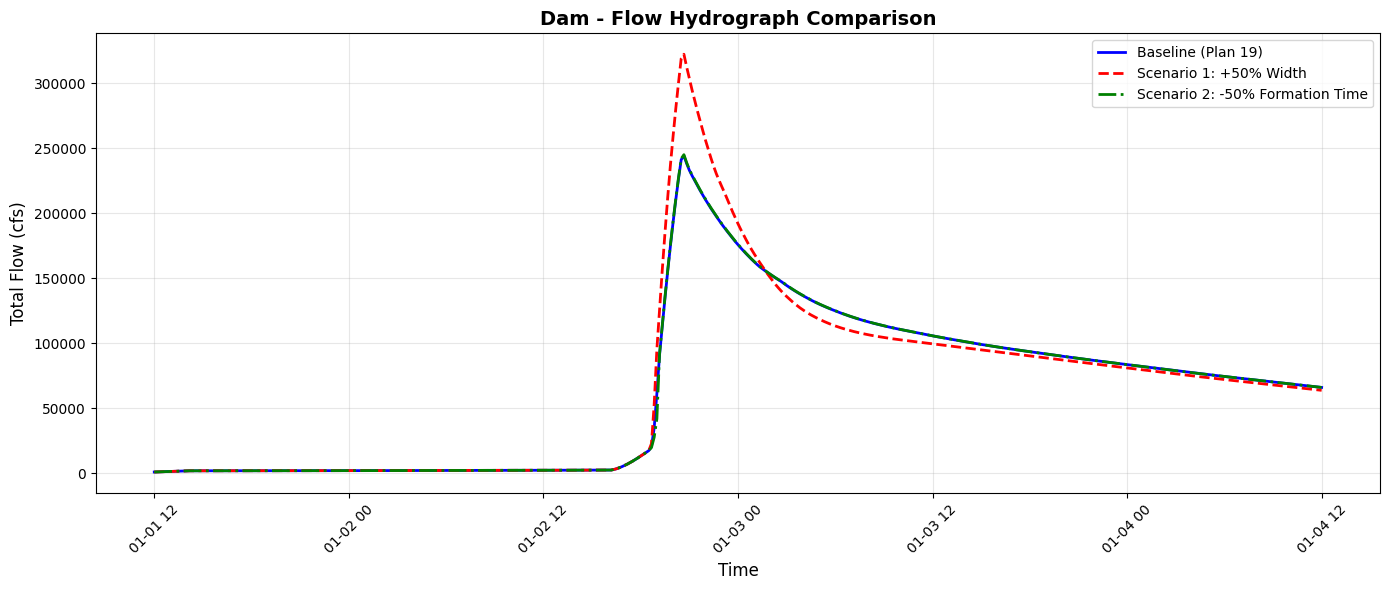

In [28]:
if scenarios:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    linestyles = ['-', '--', '-.', ':', '-']
    
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        color = colors[idx % len(colors)]
        linestyle = linestyles[idx % len(linestyles)]
        
        ax.plot(ts_data['datetime'], ts_data['total_flow'],
               label=scenario_name, color=color, linestyle=linestyle, linewidth=2)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Total Flow (cfs)', fontsize=12)
    ax.set_title(f'{target_structure} - Flow Hydrograph Comparison', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No scenario data available for comparison")

### 5.2 Peak Flow Comparison (Bar Chart)

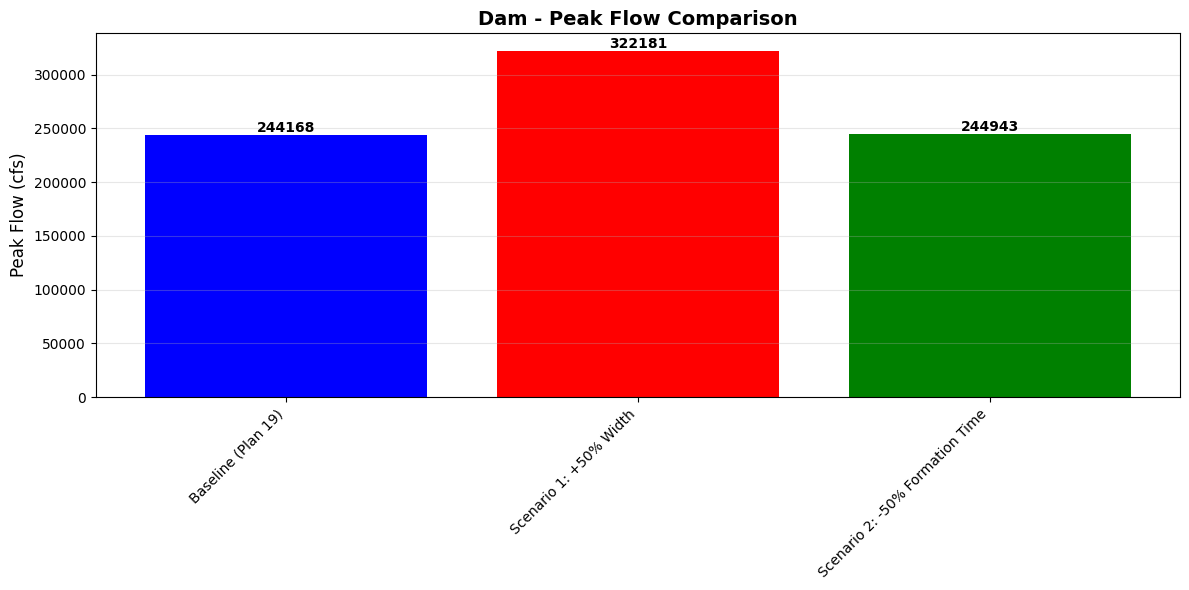


Peak Flow Differences from Baseline:
Baseline (Plan 19): 244168 cfs (baseline)
Scenario 1: +50% Width: 322181 cfs (+32.0%)
Scenario 2: -50% Formation Time: 244943 cfs (+0.3%)


In [29]:
if summaries:
    # Extract peak flows
    scenario_names = list(summaries.keys())
    peak_flows = [summaries[name].iloc[0]['max_total_flow'] 
                 for name in scenario_names]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(scenario_names)), peak_flows, 
                  color=['blue', 'red', 'green', 'orange', 'purple'][:len(scenario_names)])
    
    ax.set_xticks(range(len(scenario_names)))
    ax.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax.set_ylabel('Peak Flow (cfs)', fontsize=12)
    ax.set_title(f'{target_structure} - Peak Flow Comparison', 
                fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, peak_flows):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{value:.0f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print percent differences from baseline
    if len(peak_flows) > 1:
        baseline_flow = peak_flows[0]
        print("\nPeak Flow Differences from Baseline:")
        print("=" * 60)
        for i, (name, flow) in enumerate(zip(scenario_names, peak_flows)):
            if i == 0:
                print(f"{name}: {flow:.0f} cfs (baseline)")
            else:
                diff_pct = ((flow - baseline_flow) / baseline_flow) * 100
                print(f"{name}: {flow:.0f} cfs ({diff_pct:+.1f}%)")
else:
    print("No summary data available for comparison")

### 5.3 Breach Width Evolution Comparison

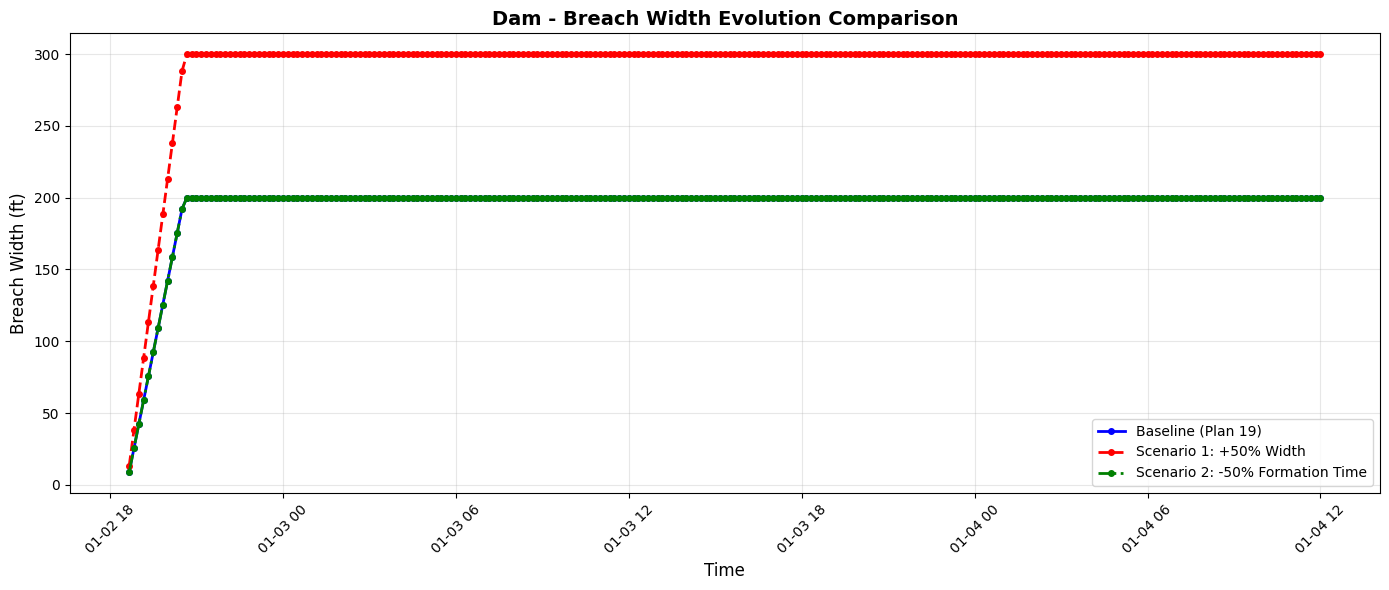

In [30]:
if scenarios:
    # Check if any scenario has breach width data
    has_width_data = any(ts['bottom_width'].notna().any() for ts in scenarios.values())
    
    if has_width_data:
        fig, ax = plt.subplots(figsize=(14, 6))
        
        for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
            if ts_data['bottom_width'].notna().any():
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                
                ax.plot(ts_data['datetime'], ts_data['bottom_width'],
                       label=scenario_name, color=color, linestyle=linestyle, 
                       linewidth=2, marker='o', markersize=4)
        
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Breach Width (ft)', fontsize=12)
        ax.set_title(f'{target_structure} - Breach Width Evolution Comparison', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No breach width data available (breach may not have formed)")
else:
    print("No scenario data available for comparison")

### 5.4 Summary Table Comparison

In [31]:
if summaries:
    # Combine all summaries into a comparison table
    comparison_data = []
    for scenario_name, summary_df in summaries.items():
        row = summary_df.iloc[0].to_dict()
        row['Scenario'] = scenario_name
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Select key columns for display
    display_cols = ['Scenario', 'max_total_flow', 'max_breach_flow', 
                   'final_breach_width', 'final_breach_depth', 
                   'max_hw', 'max_tw']
    
    # Filter to available columns
    display_cols = [col for col in display_cols if col in comparison_df.columns]
    
    print("\nScenario Comparison Summary:")
    print("=" * 100)
    print(comparison_df[display_cols].to_string(index=False))
    
    # Export to CSV
    output_file = project_path / "breach_scenario_comparison.csv"
    comparison_df.to_csv(output_file, index=False)
    print(f"\nComparison table exported to: {output_file}")
else:
    print("No summary data available for comparison table")


Scenario Comparison Summary:
                       Scenario  max_total_flow  max_breach_flow  final_breach_width  final_breach_depth     max_hw     max_tw
             Baseline (Plan 19)   244167.781250    238721.250000               200.0           23.746826 661.506348 615.288330
         Scenario 1: +50% Width   322181.406250    319811.718750               300.0           18.406982 661.338684 618.665955
Scenario 2: -50% Formation Time   244943.171875    239246.484375               200.0           23.746826 661.606323 615.312927

Comparison table exported to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16\breach_scenario_comparison.csv


### 5.5 Comprehensive Multi-Panel Comparison

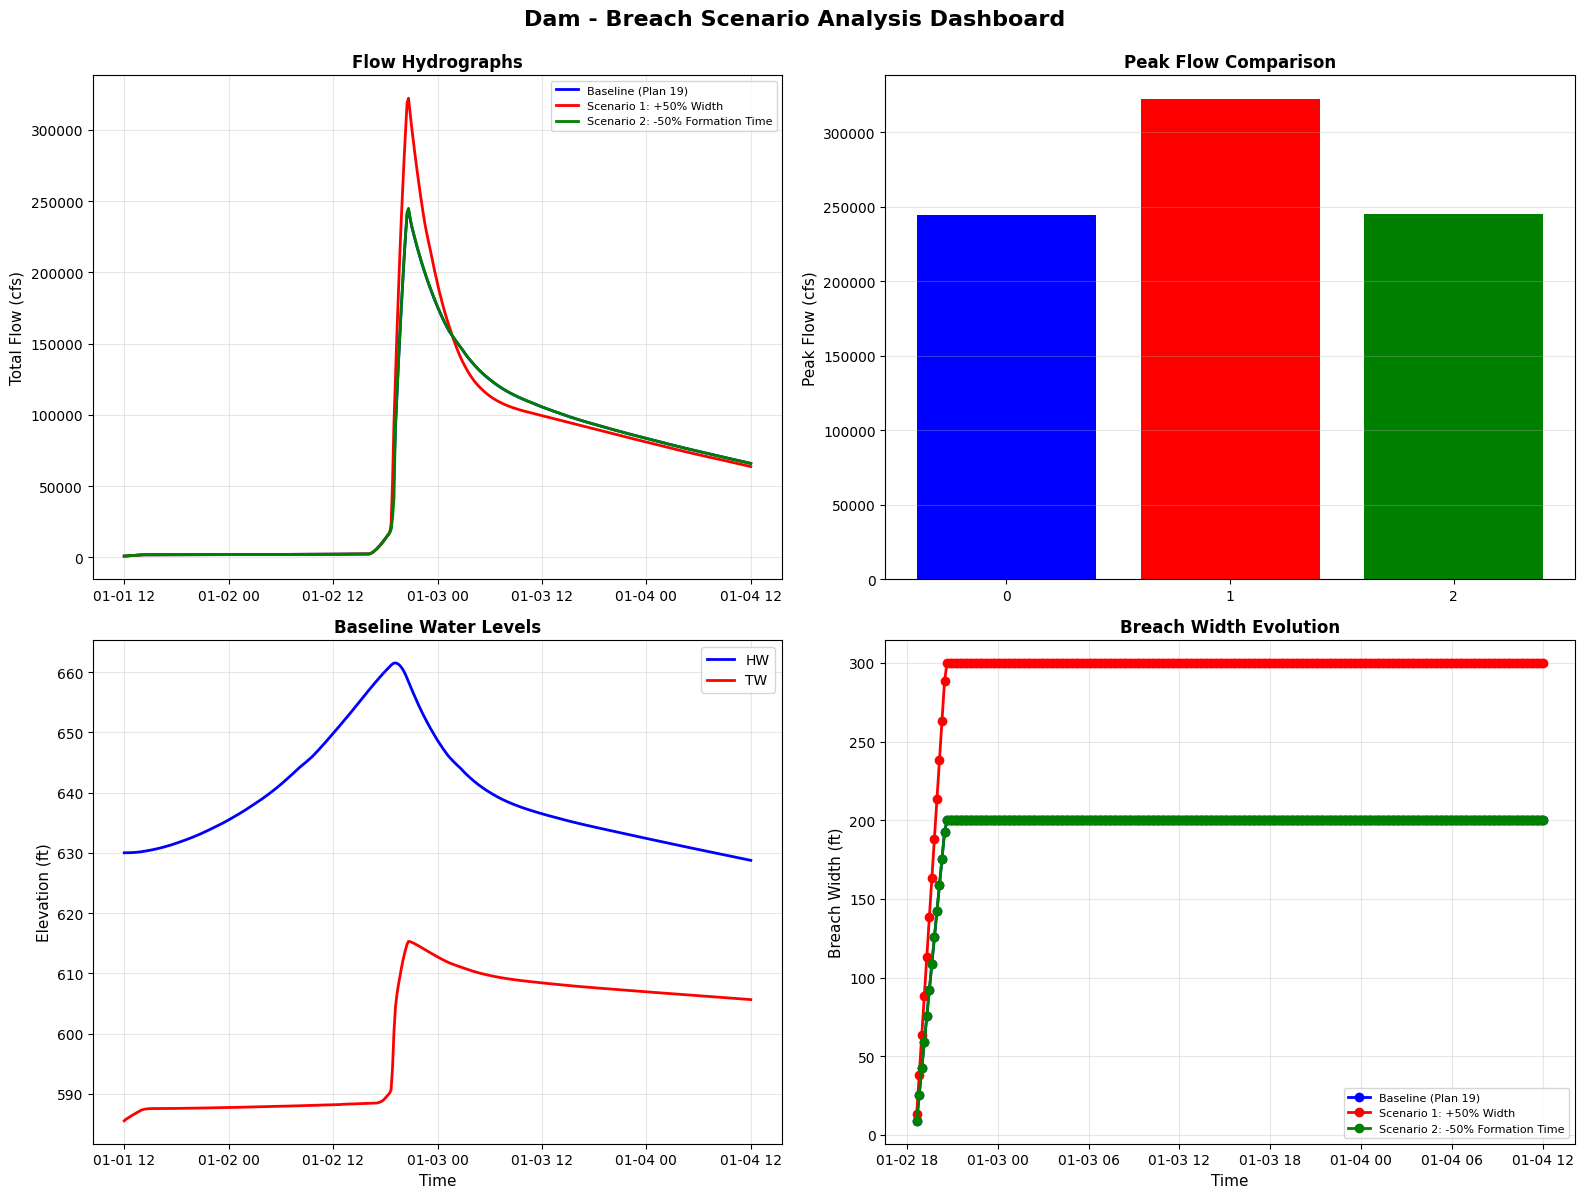

In [32]:
if scenarios and len(scenarios) > 1:
    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Flow comparison
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        color = colors[idx % len(colors)]
        axes[0, 0].plot(ts_data['datetime'], ts_data['total_flow'],
                       label=scenario_name, color=color, linewidth=2)
    axes[0, 0].set_ylabel('Total Flow (cfs)', fontsize=11)
    axes[0, 0].set_title('Flow Hydrographs', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Peak flows bar chart
    scenario_names = list(summaries.keys())
    peak_flows = [summaries[name].iloc[0]['max_total_flow'] for name in scenario_names]
    bars = axes[0, 1].bar(range(len(scenario_names)), peak_flows,
                          color=colors[:len(scenario_names)])
    axes[0, 1].set_xticks(range(len(scenario_names)))
    axes[0, 1].set_xticklabels(range(len(scenario_names)))
    axes[0, 1].set_ylabel('Peak Flow (cfs)', fontsize=11)
    axes[0, 1].set_title('Peak Flow Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, axis='y', alpha=0.3)
    
    # Plot 3: HW/TW for baseline
    baseline_ts = scenarios[list(scenarios.keys())[0]]
    axes[1, 0].plot(baseline_ts['datetime'], baseline_ts['hw'], 
                   label='HW', color='blue', linewidth=2)
    axes[1, 0].plot(baseline_ts['datetime'], baseline_ts['tw'], 
                   label='TW', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Time', fontsize=11)
    axes[1, 0].set_ylabel('Elevation (ft)', fontsize=11)
    axes[1, 0].set_title('Baseline Water Levels', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Breach width comparison (if available)
    has_width = False
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        if ts_data['bottom_width'].notna().any():
            color = colors[idx % len(colors)]
            axes[1, 1].plot(ts_data['datetime'], ts_data['bottom_width'],
                           label=scenario_name, color=color, linewidth=2, marker='o')
            has_width = True
    
    if has_width:
        axes[1, 1].set_xlabel('Time', fontsize=11)
        axes[1, 1].set_ylabel('Breach Width (ft)', fontsize=11)
        axes[1, 1].set_title('Breach Width Evolution', fontsize=12, fontweight='bold')
        axes[1, 1].legend(fontsize=8)
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Breach Width Data',
                       ha='center', va='center', fontsize=14,
                       transform=axes[1, 1].transAxes)
    
    fig.suptitle(f'{target_structure} - Breach Scenario Analysis Dashboard',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 scenarios for comprehensive comparison")

## 6. Export All Results

In [33]:
if scenarios:
    # Export each scenario's time series
    for scenario_name, ts_data in scenarios.items():
        # Create safe filename
        safe_name = scenario_name.replace(' ', '_').replace(':', '').replace('+', 'plus')
        filename = project_path / f"breach_{safe_name}.csv"
        ts_data.to_csv(filename, index=False)
        print(f"Exported: {filename.name}")
    
    print(f"\nAll scenario data exported to: {project_path}")
else:
    print("No scenario data to export")

Exported: breach_Baseline_(Plan_19).csv
Exported: breach_Scenario_1_plus50%_Width.csv
Exported: breach_Scenario_2_-50%_Formation_Time.csv

All scenario data exported to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_16


## Summary

This notebook demonstrated:

**✅ Baseline Analysis:**
- Extracted existing breach results from HDF
- Read baseline breach parameters from plan file
- Visualized baseline behavior

**✅ Scenario Creation:**
- Cloned plans to create new scenarios
- Modified breach parameters one at a time:
  - Scenario 1: Increased breach width by 50%
  - Scenario 2: Decreased formation time by 50%

**✅ Results Comparison:**
- Extracted results from all scenarios
- Compared flow hydrographs
- Compared peak flows
- Compared breach geometry evolution
- Created comprehensive comparison dashboard

**✅ Data Export:**
- Exported time series for all scenarios
- Exported comparison summary table

### Key Functions Used:

```python
# HDF Results Extraction (use HdfResultsBreach and HdfStruc)
HdfStruc.list_sa2d_connections(plan)              # List structures in HDF
HdfStruc.get_sa2d_breach_info(plan)               # Get breach capability info
HdfResultsBreach.get_breach_timeseries(plan, structure)   # Extract time series
HdfResultsBreach.get_breach_summary(plan, structure)      # Extract summary stats
HdfResultsBreach.get_breaching_variables(plan, structure) # Breach geometry evolution
HdfResultsBreach.get_structure_variables(plan, structure) # Structure flow variables

# Plan File Parameter Management (use RasBreach)
RasBreach.list_breach_structures_plan(plan)      # List structures in plan file
RasBreach.read_breach_block(plan, structure)     # Read parameters
RasBreach.update_breach_block(plan, structure, geom_values=[...])  # Modify parameters
```

### Architectural Pattern:

**ras-commander separates HDF and plain text operations:**
- **RasBreach** → Breach PARAMETERS in plan files (.p##)
- **HdfResultsBreach** → Breach RESULTS from HDF files (.p##.hdf)
- **HdfStruc** → Structure listings and metadata from HDF

**Important:** Use plan file methods for parameter operations to ensure structure names match!

### Breach Geom Field Structure:
```python
# Breach Geom CSV format (10 fields):
[0] Centerline/Station     # ft
[1] Initial Bottom Width   # ft
[2] Final Bottom Elevation # ft  <-- Example: change this to 605
[3] Left Side Slope        # H:V ratio
[4] Right Side Slope       # H:V ratio
[5] Active Flag            # True/False
[6] Weir Coefficient       # dimensionless
[7] Top Elevation          # ft
[8] Formation Method       # 1=Time, 2=Trigger
[9] Formation Time/Threshold # hrs or ft

# Example: Update Final Bottom Elevation
new_geom = baseline_geom.copy()
new_geom[2] = 605  # Set to 605 ft
RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)
```